In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from mlforecast import MLForecast
import optuna

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [4]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

lags = [1,2,3,4,5,6,7,8,9,10,11,12]

evaluator = MetricEvaluator()

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


### Raw model

In [5]:
model = make_pipeline(
    MinMaxScaler(feature_range=(0,1)), 
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
)

fcst = MLForecast(
    models={'svr': model},
    lags=lags,
    freq='MS'
)

# params found here https://www.nature.com/articles/s41598-024-74503-4/tables/7

In [6]:
fcst.fit(full_train)

MLForecast(models=[svr], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [7]:
fcst.models_['svr'].named_steps['svr']

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,C,10.0
,epsilon,0.25
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [8]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [8]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [9]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['svr'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE            MSE  \
0    ACUCAR_SANTOS   svr              20    8.567765  0.057128     101.479875   
1        ACUCAR_SP   svr             100    9.430774  0.096234     130.085473   
2          ALGODAO   svr             205   23.323948  0.066336    1098.430616   
3            ARROZ   svr             277    3.690311  0.056296      44.266369   
4     CAFE_ARABICA   svr             381  115.606698  0.094725  123683.198936   
5     CAFE_ROBUSTA   svr             468   87.007968  0.192031   40558.106224   
6            MILHO   svr             543    1.142715  0.017799      13.170196   
7      SOJA_PARANA   svr             644    3.243237  0.036712      33.124777   
8   SOJA_PARANAGUA   svr             714    8.092339  0.089856      77.317104   
9     TRIGO_PARANA   svr             791  294.993483  0.296735  152143.365619   
10        TRIGO_RS   svr             868  193.622828  0.201859   96528.623960   

          RMSE        R2  


In [10]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                       MAPE                 \
          mean      std     min       max  median    mean    std     min   
Model                                                                      
svr    68.0656  97.6121  1.1427  294.9935  9.4308  0.1096  0.085  0.0178   

                              MSE                                              \
          max  median        mean         std      min          max    median   
Model                                                                           
svr    0.2967  0.0899  37673.7426  58134.9257  13.1702  152143.3656  130.0855   

           RMSE                                           R2                \
           mean       std     min       max   median    mean    std    min   
Model                                                                        
svr    121.2069  158.9997  3.6291  390.0556  11.4055  0.0195  1.437 -3.332   

                       
    

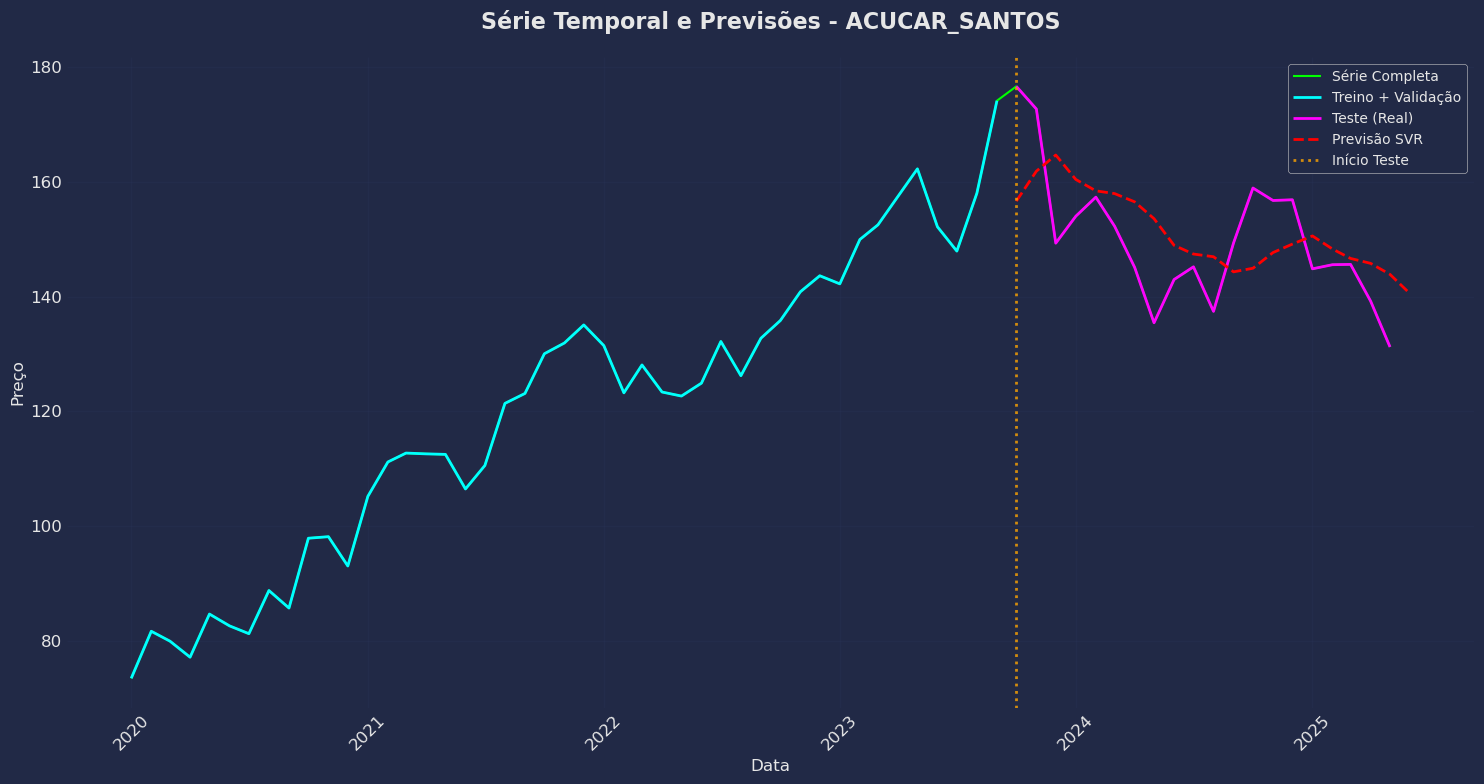

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


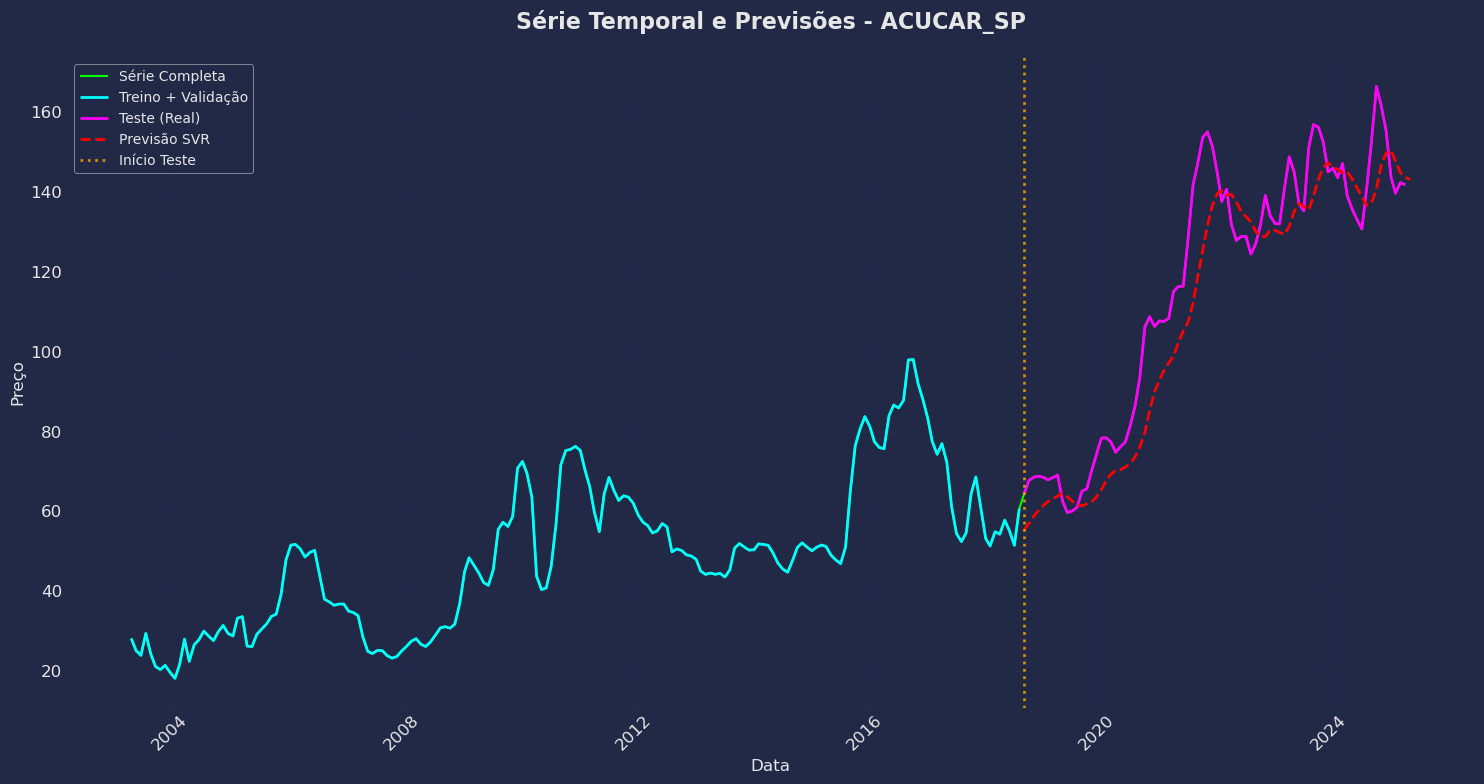

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


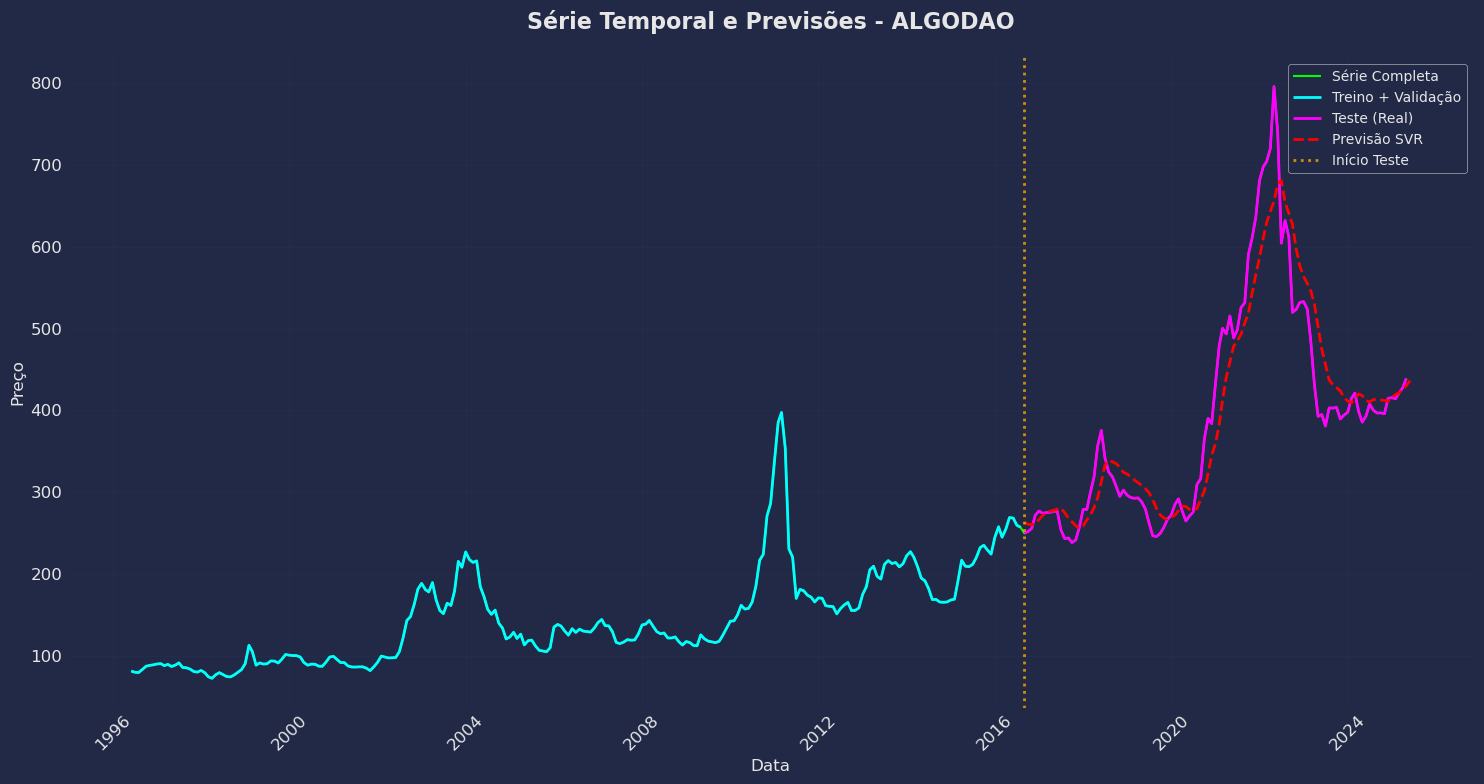

Gráfico exibido para: ALGODAO
--------------------------------------------------


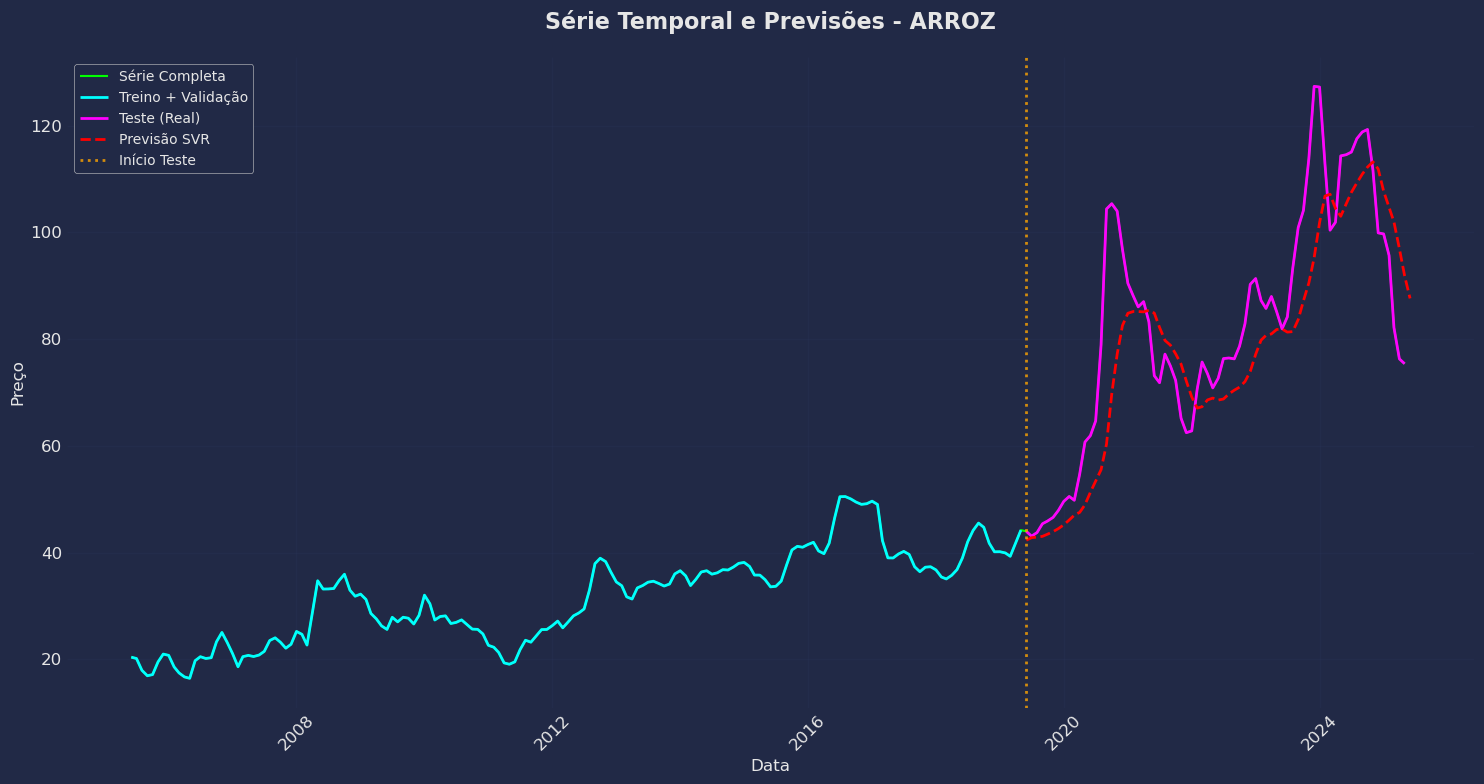

Gráfico exibido para: ARROZ
--------------------------------------------------


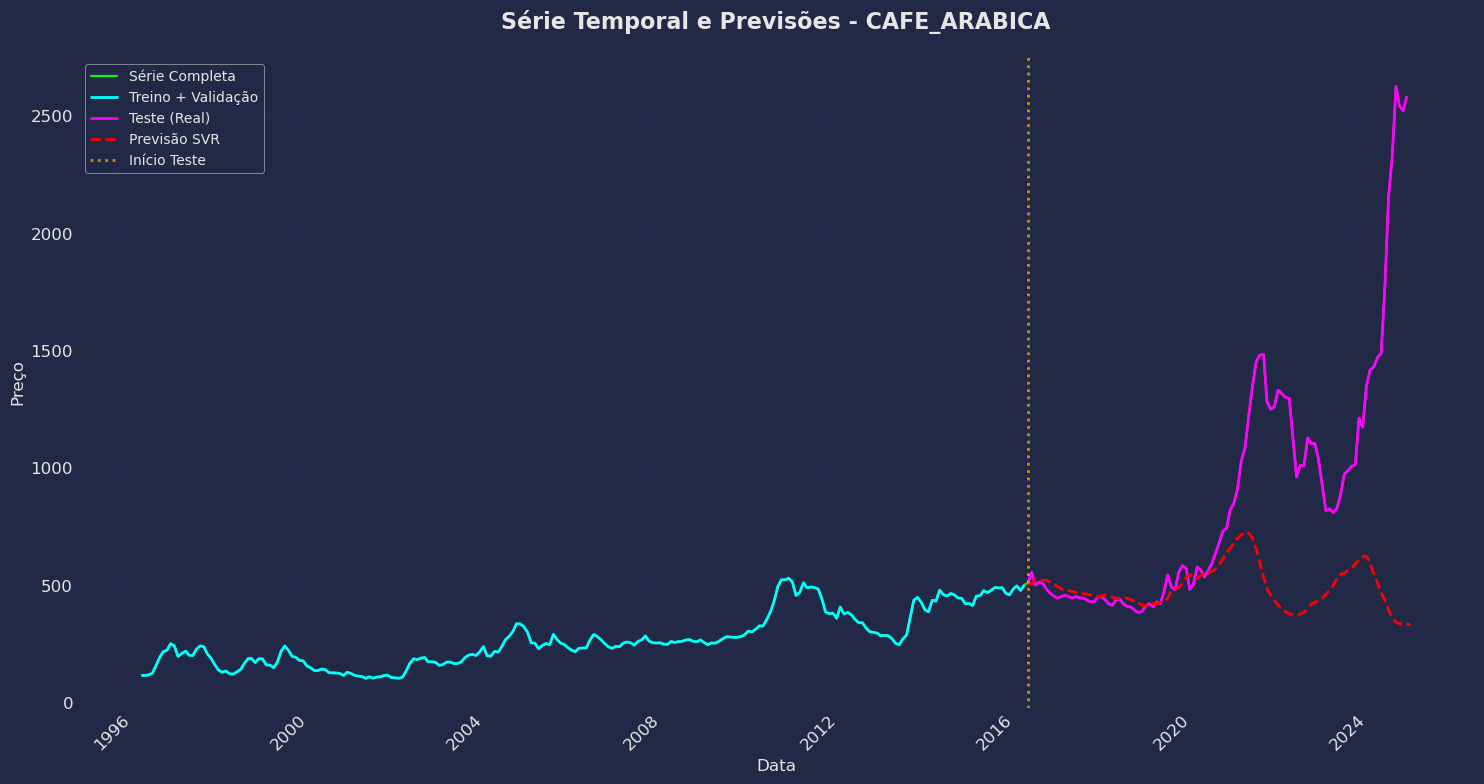

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


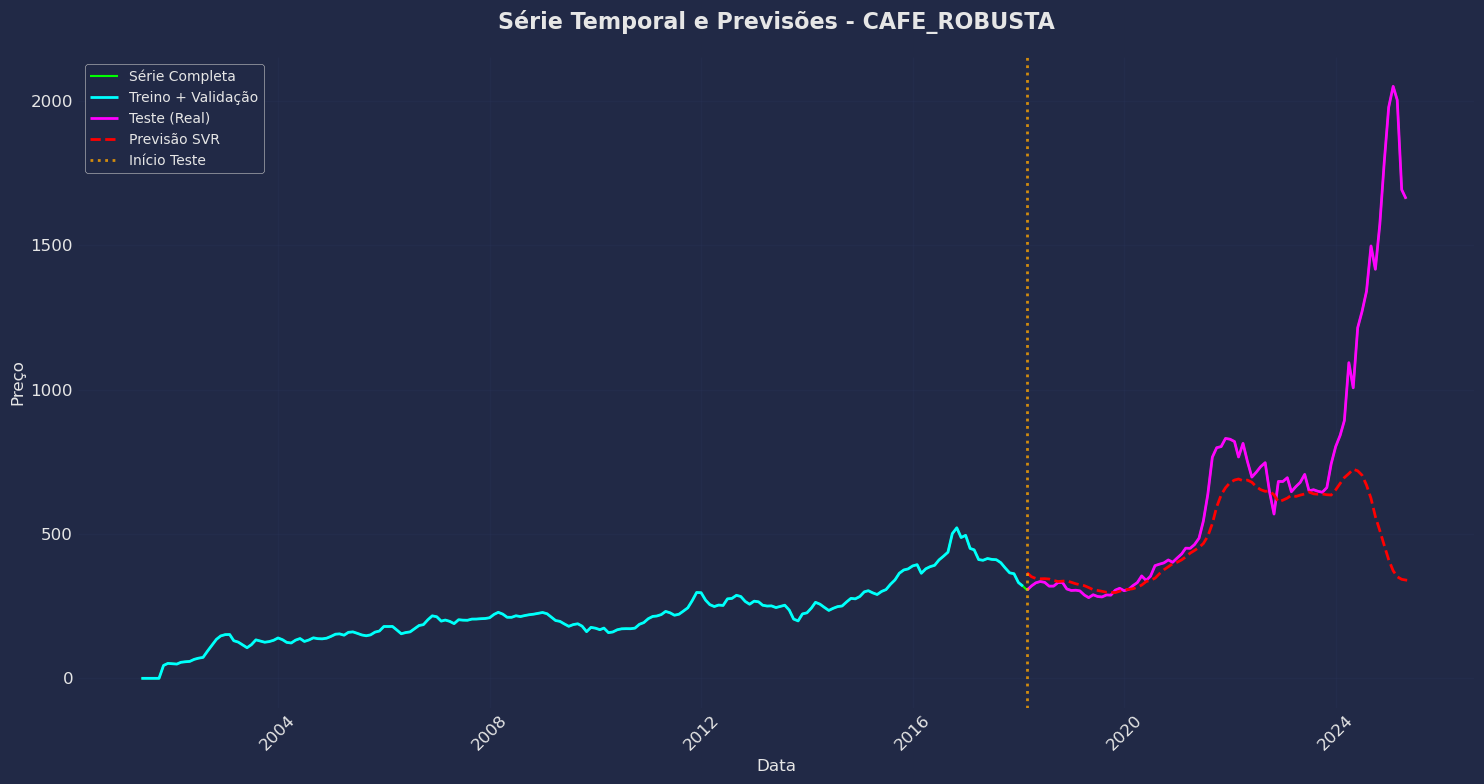

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


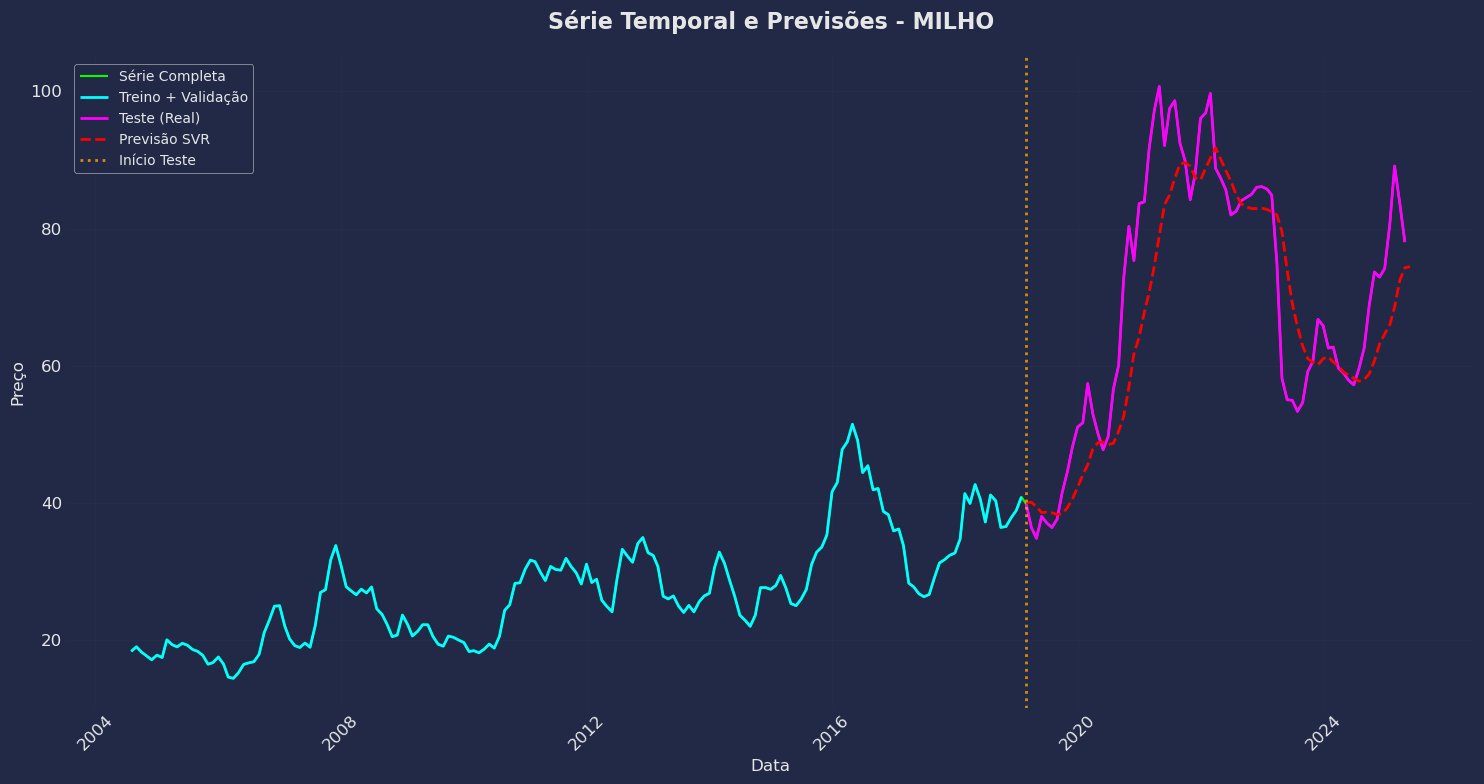

Gráfico exibido para: MILHO
--------------------------------------------------


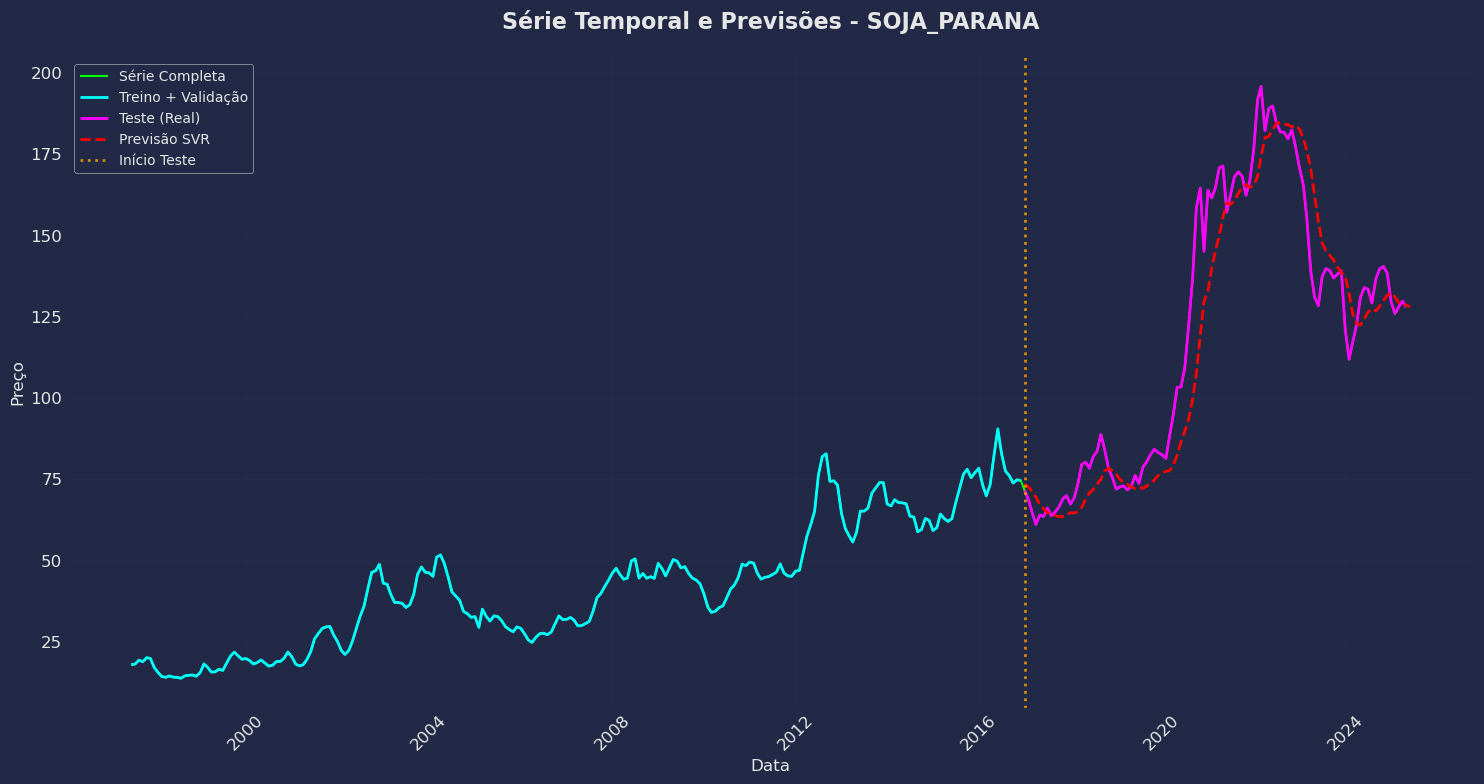

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


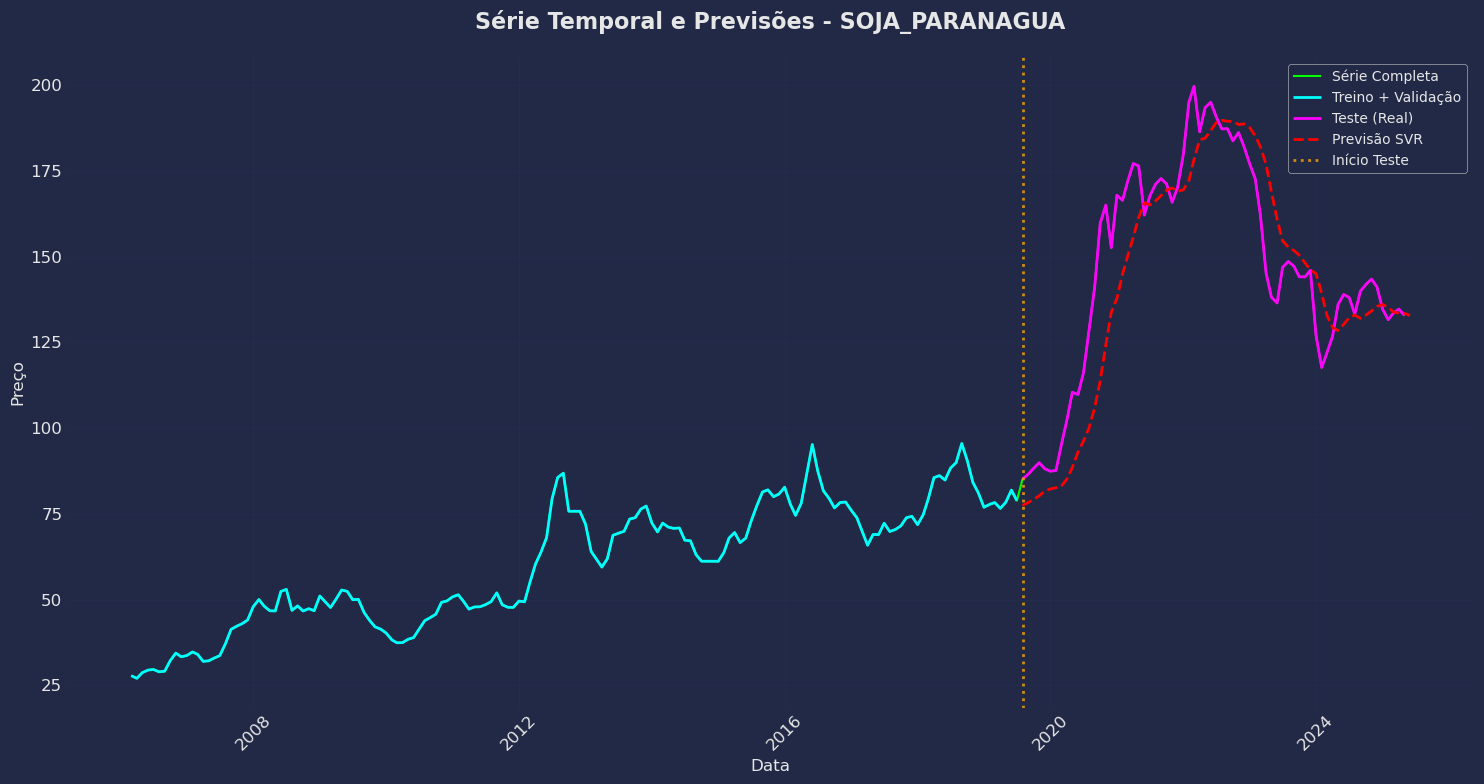

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


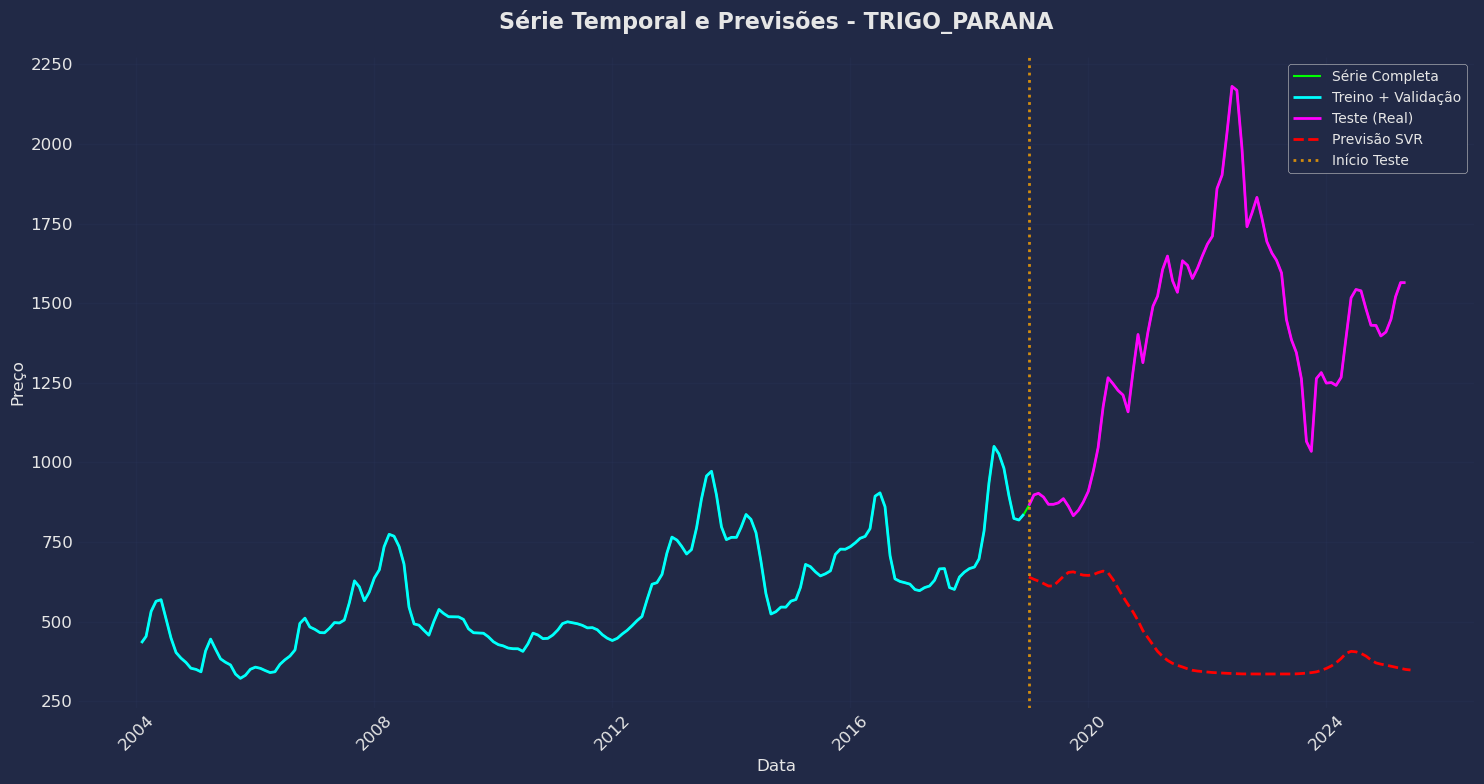

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


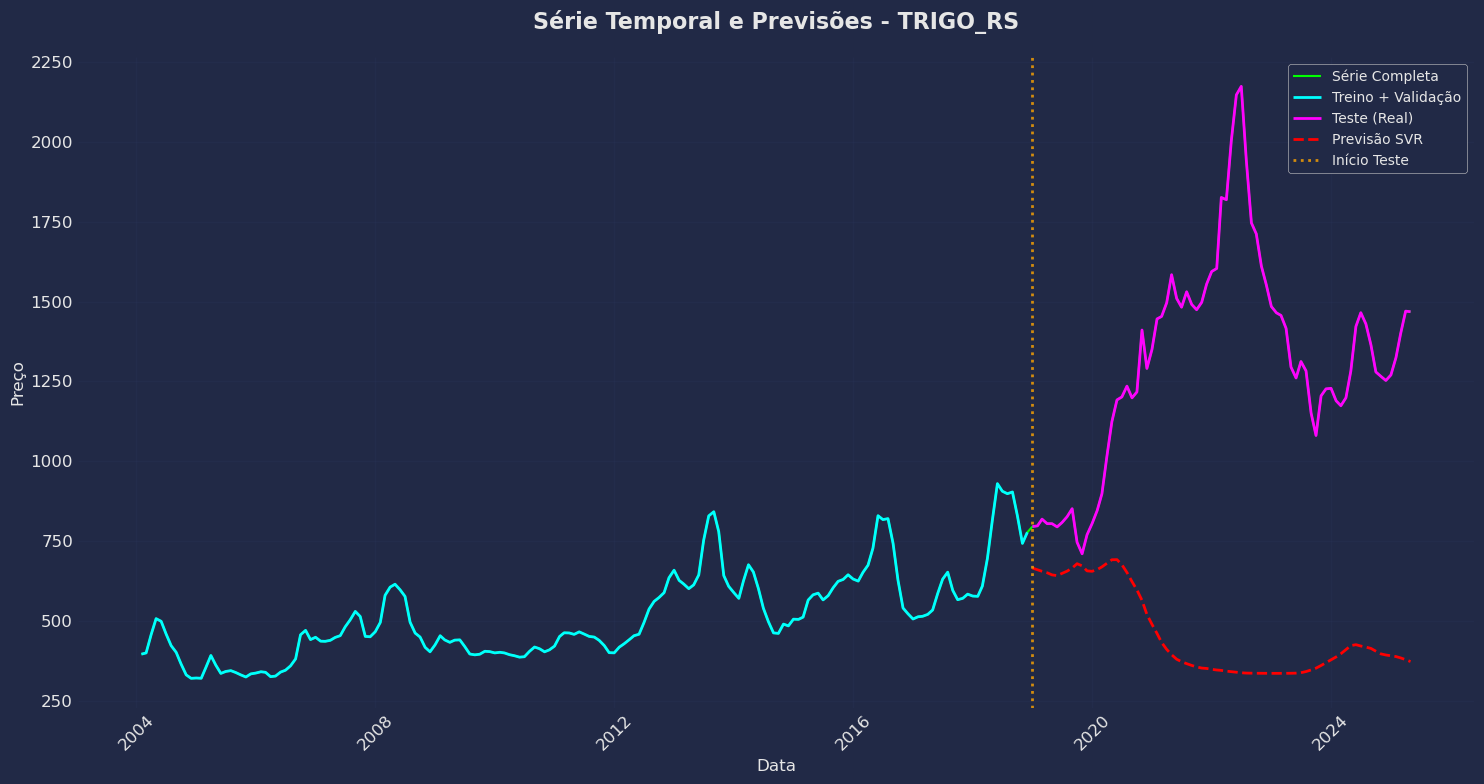

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [11]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['svr'], 
                color='red', linewidth=2, linestyle='--', label='Previsão SVR')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

### Tunned

In [12]:
def mae_from_forecasts(forecasts_df, actual_df, model_col='svr'):
    df = forecasts_df.merge(actual_df[['unique_id','ds','y']], 
                            on=['unique_id','ds'], how='inner')
    if len(df) == 0:
        return np.inf
    return mean_absolute_error(df['y'], df[model_col])

In [13]:
def objective(trial):
    C = trial.suggest_categorical("C", [0.025, 0.5, 0.75, 1, 1.15, 1.25, 2, 3, 4, 10, 20, 100, 128])
    gamma = trial.suggest_categorical("gamma", [0.5, 0.25, 0.125, 0.1])
    epsilon = trial.suggest_categorical("epsilon", [0.25, 0.1, 0.0625, 0.03125])
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"])
    
    # modelo pipeline com MinMaxScaler
    model = make_pipeline(
        MinMaxScaler(feature_range=(0,1)),
        SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    )
    
    fcst = MLForecast(models={'svr': model}, lags=lags, freq='MS')
    fcst.fit(train)
    
    preds = []
    for i in range(len(val)):
        f_next = fcst.predict(h=1)
        preds.append(f_next)
        obs = val.iloc[[i]][['unique_id','ds','y']]
        fcst.update(obs)
    
    forecasts_df = pd.concat(preds, ignore_index=True)
    mae = mae_from_forecasts(forecasts_df, val, model_col='svr')
    
    return mae

# https://www.mdpi.com/2227-9091/11/2/27
# https://www.sciencedirect.com/science/article/abs/pii/S1568494619306180?via%3Dihub
# https://www.nature.com/articles/s41598-024-74503-4#Tab7
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10908409
# https://www.sciencedirect.com/science/article/abs/pii/S1057521923004696?via%3Dihub
# https://onlinelibrary.wiley.com/doi/full/10.1002/isaf.1459

In [14]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

study.optimize(objective, n_trials=80, n_jobs=1)

print("Melhor score (val):", study.best_value)
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-10-12 16:22:13,079] A new study created in memory with name: no-name-d91bf617-375e-4717-9b05-efde5d34aa87
[I 2025-10-12 16:22:17,370] Trial 0 finished with value: 88.23944877400616 and parameters: {'C': 100, 'gamma': 0.1, 'epsilon': 0.03125, 'kernel': 'sigmoid'}. Best is trial 0 with value: 88.23944877400616.
[I 2025-10-12 16:22:21,434] Trial 1 finished with value: 10.643256266229265 and parameters: {'C': 20, 'gamma': 0.25, 'epsilon': 0.0625, 'kernel': 'linear'}. Best is trial 1 with value: 10.643256266229265.
[I 2025-10-12 16:22:25,260] Trial 2 finished with value: 46.45375945878262 and parameters: {'C': 0.75, 'gamma': 0.25, 'epsilon': 0.0625, 'kernel': 'linear'}. Best is trial 1 with value: 10.643256266229265.
[I 2025-10-12 16:22:29,442] Trial 3 finished with value: 60.08176616527657 and parameters: {'C': 4, 'gamma': 0.1, 'epsilon': 0.03125, 'kernel': 'rbf'}. Best is trial 1 with value: 10.643256266229265.
[I 2025-10-12 16:22:36,486] Trial 4 finished with value: 60.0550302325

KeyboardInterrupt: 

In [ ]:
best = study.best_params
svr_best = SVR(C=best['C'], epsilon=best['epsilon'], kernel=best['kernel'], gamma=best['gamma'])
model_best = make_pipeline(MinMaxScaler(feature_range=(0,1)), svr_best)

fcst_final = MLForecast(models={'svr': model_best}, lags=lags, freq='MS')
fcst_final.fit(full_train)

MLForecast(models=[svr], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [ ]:
import os
import joblib
# import pmdarima as pm
# from tensorflow.keras.models import save_model as keras_save_model

SAVE_DIR = "/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/"

# Garante que o diretório exista
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model(model, name: str):
    """
    Salva modelos de sklearn, keras e pmdarima no formato adequado.

    Parâmetros:
    - model: objeto do modelo treinado
    - name: nome do arquivo (sem extensão)
    """
    path = os.path.join(SAVE_DIR, name)

    # --- Keras (Sequential, Functional, etc.)
    # if 'tensorflow' in str(type(model)).lower() or 'keras' in str(type(model)).lower():
    #     model.save(f"{path}.keras")
    #     print(f"✅ Modelo Keras salvo em: {path}.keras")

    # # --- pmdarima
    # elif 'ARIMA' in str(type(model)):
    #     pm.arima.save_arima(model, f"{path}.pkl")
    #     print(f"✅ Modelo ARIMA salvo em: {path}.pkl")

    # --- sklearn (MLP, RF, etc.)
    joblib.dump(model, f"{path}.pkl")
    print(f"✅ Modelo sklearn salvo em: {path}.pkl")

save_model(fcst_final, "svr_tunned")

✅ Modelo sklearn salvo em: /home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/svr_tunned.pkl


In [ ]:
forecasts = []
for i in range(len(test)):
    f_next = fcst_final.predict(h=1)
    forecasts.append(f_next)
    obs = test.iloc[[i]][['unique_id','ds','y']]
    fcst_final.update(obs)

forecasts_df = pd.concat(forecasts, ignore_index=True)

In [ ]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['svr'],         
    groupby_column='unique_id'     
)
print(results)
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

         unique_id Model  n_observations        MAE      MAPE          MSE  \
0    ACUCAR_SANTOS   svr              20   6.840979  0.046632    75.907358   
1        ACUCAR_SP   svr             100   4.379650  0.042533    30.289461   
2          ALGODAO   svr             205  12.173631  0.034064   406.998634   
3            ARROZ   svr             277   1.555741  0.022233    11.767449   
4     CAFE_ARABICA   svr             381  22.219135  0.029746  2241.718706   
5     CAFE_ROBUSTA   svr             468  21.534114  0.053570  1258.051628   
6            MILHO   svr             543   1.772588  0.039202     5.232600   
7      SOJA_PARANA   svr             644   4.049059  0.052020    20.141520   
8   SOJA_PARANAGUA   svr             714   5.711826  0.064367    34.952943   
9     TRIGO_PARANA   svr             791  22.451165  0.023279   971.555955   
10        TRIGO_RS   svr             868  23.110088  0.026271   934.443801   

         RMSE        R2  
0    8.712483  0.387271  
1    5.5035

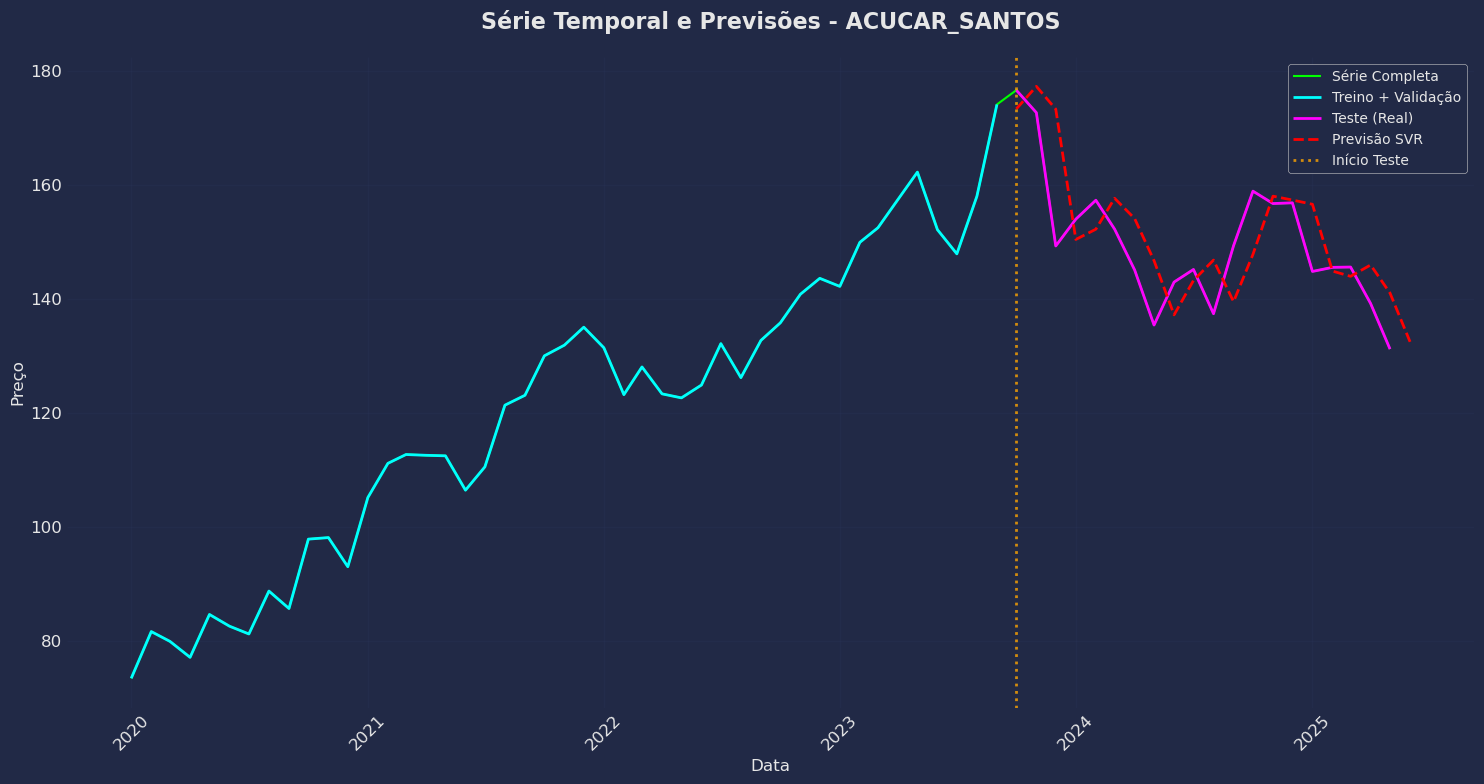

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


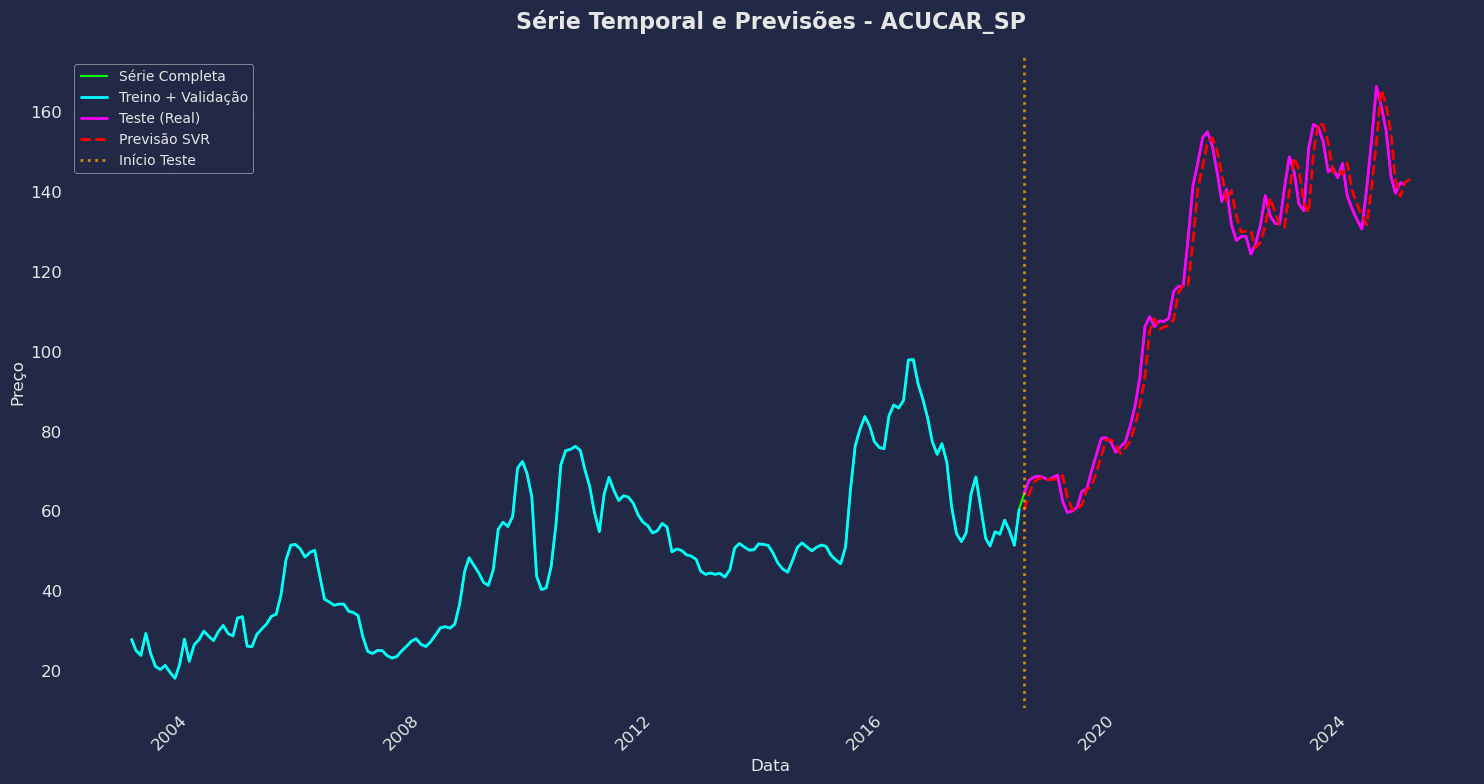

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


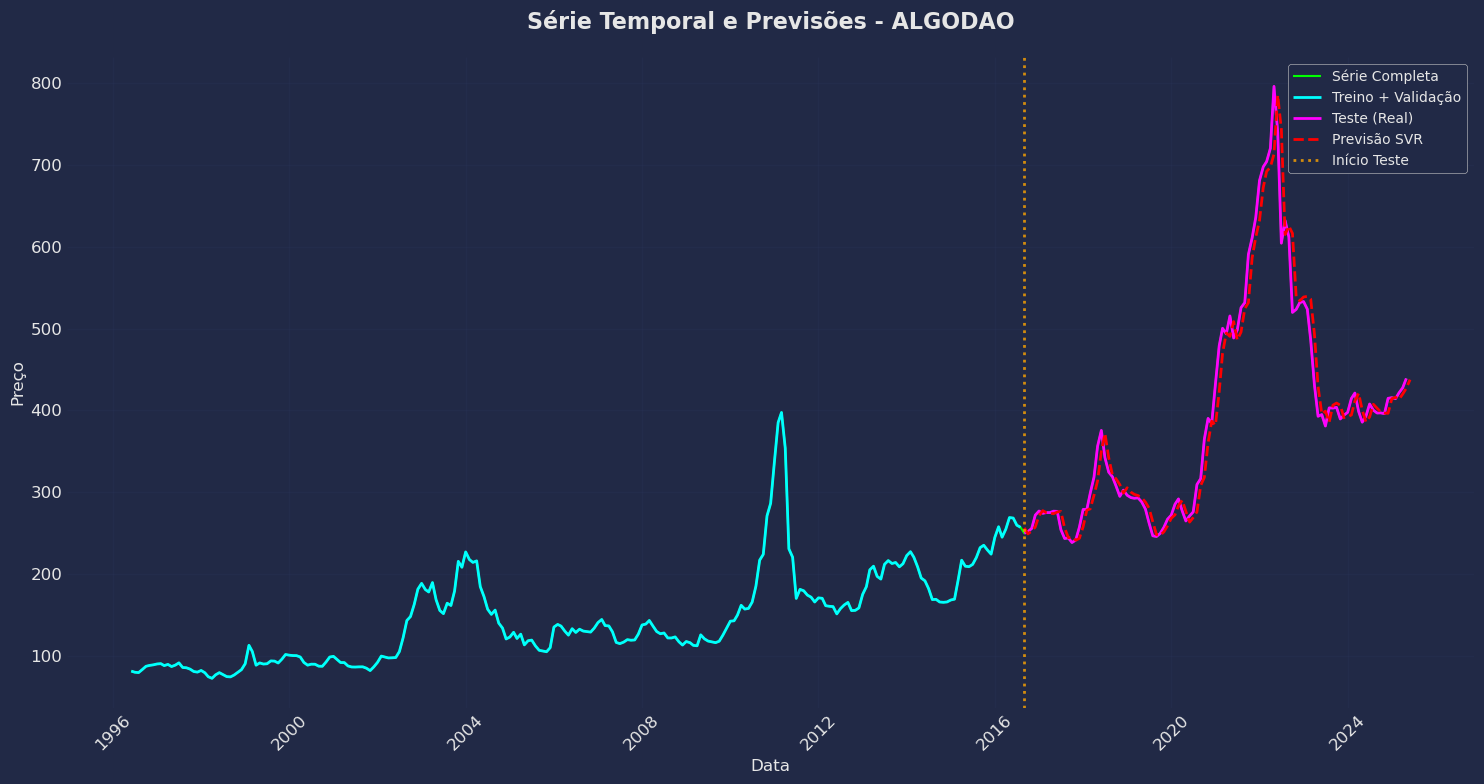

Gráfico exibido para: ALGODAO
--------------------------------------------------


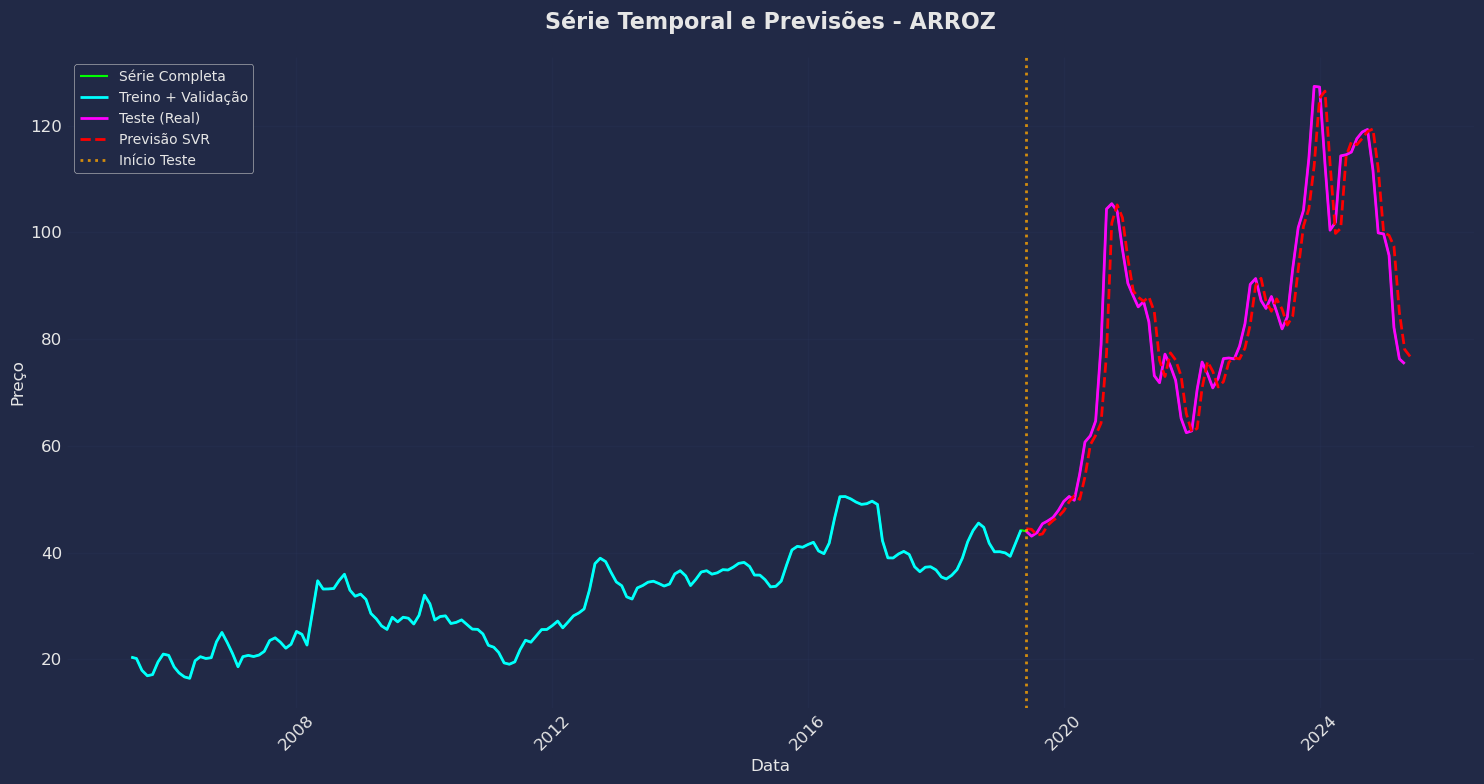

Gráfico exibido para: ARROZ
--------------------------------------------------


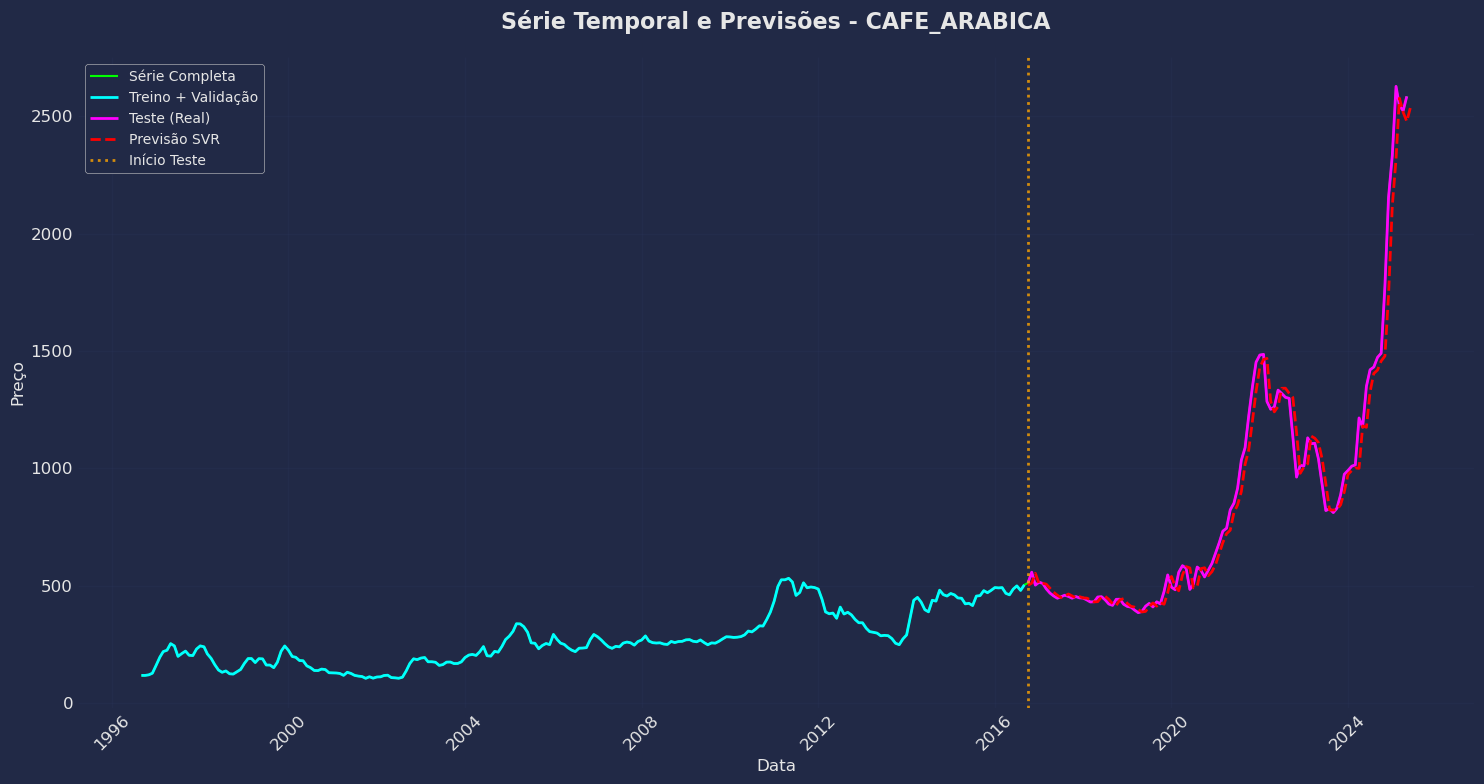

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


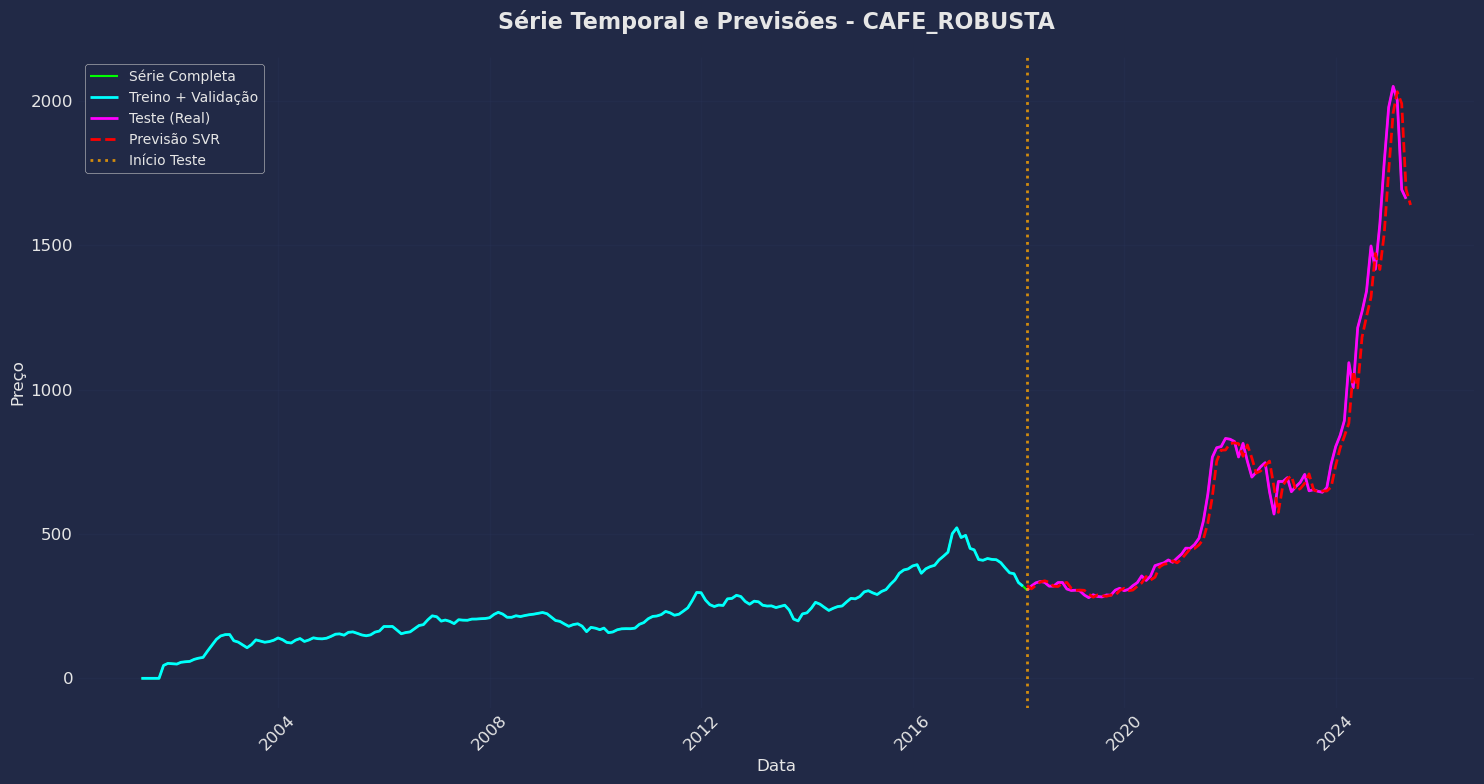

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


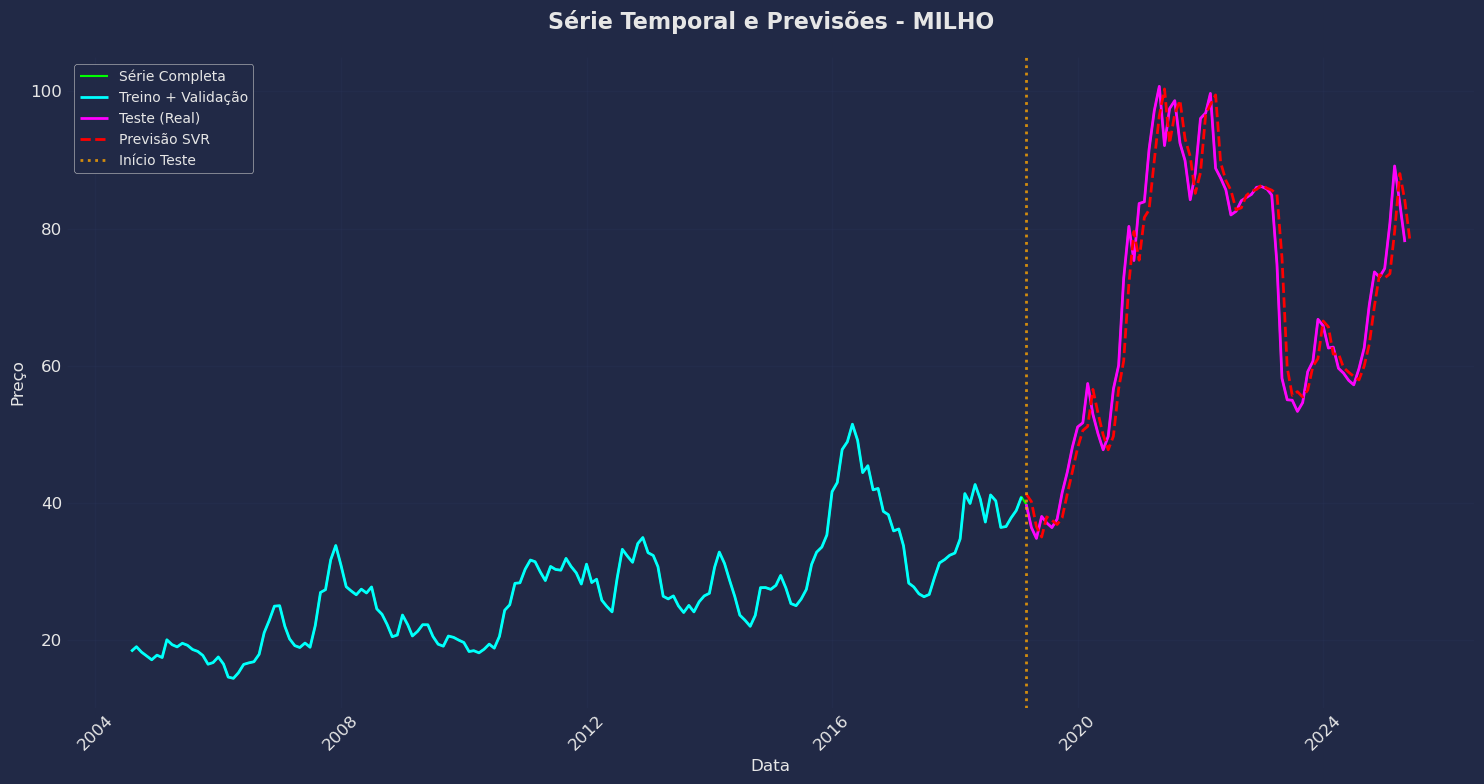

Gráfico exibido para: MILHO
--------------------------------------------------


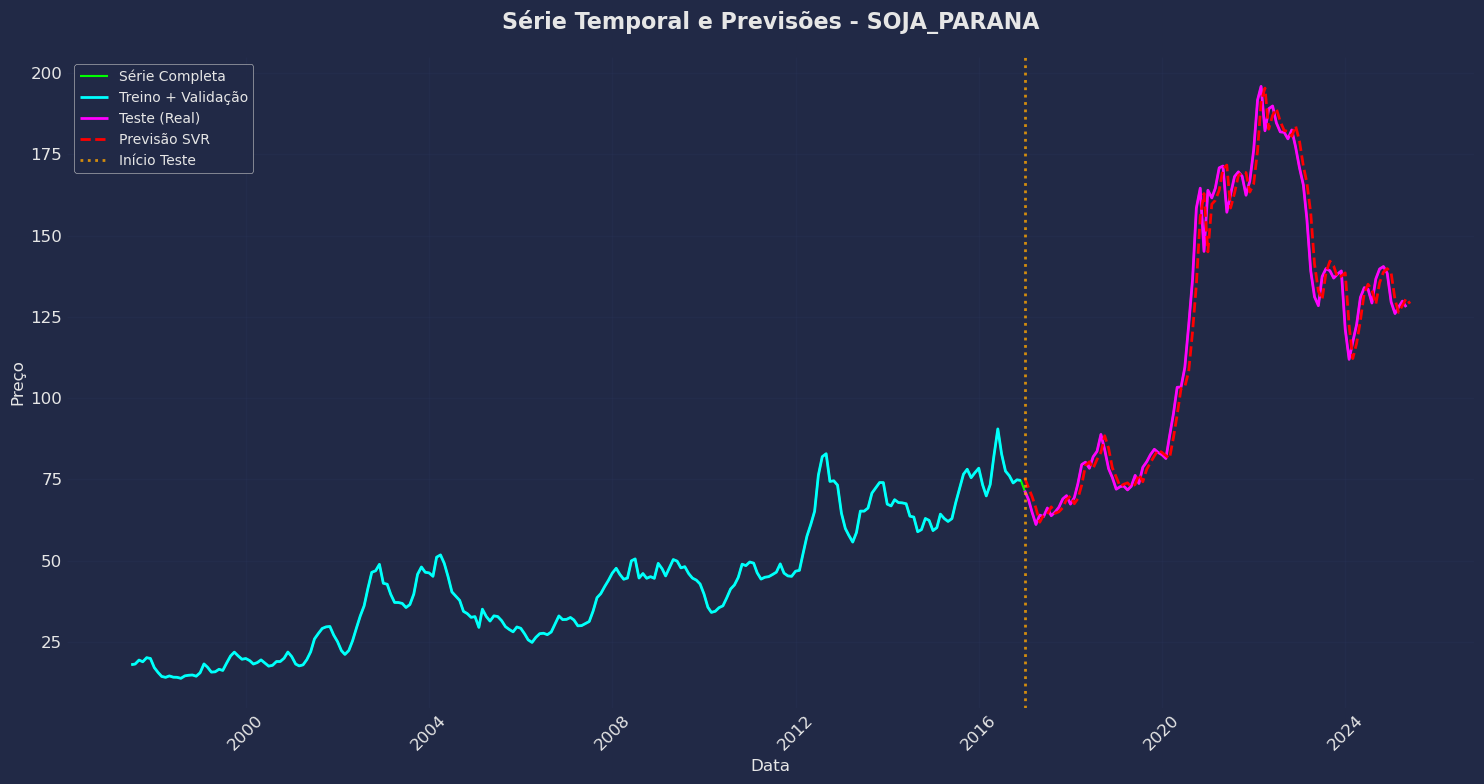

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


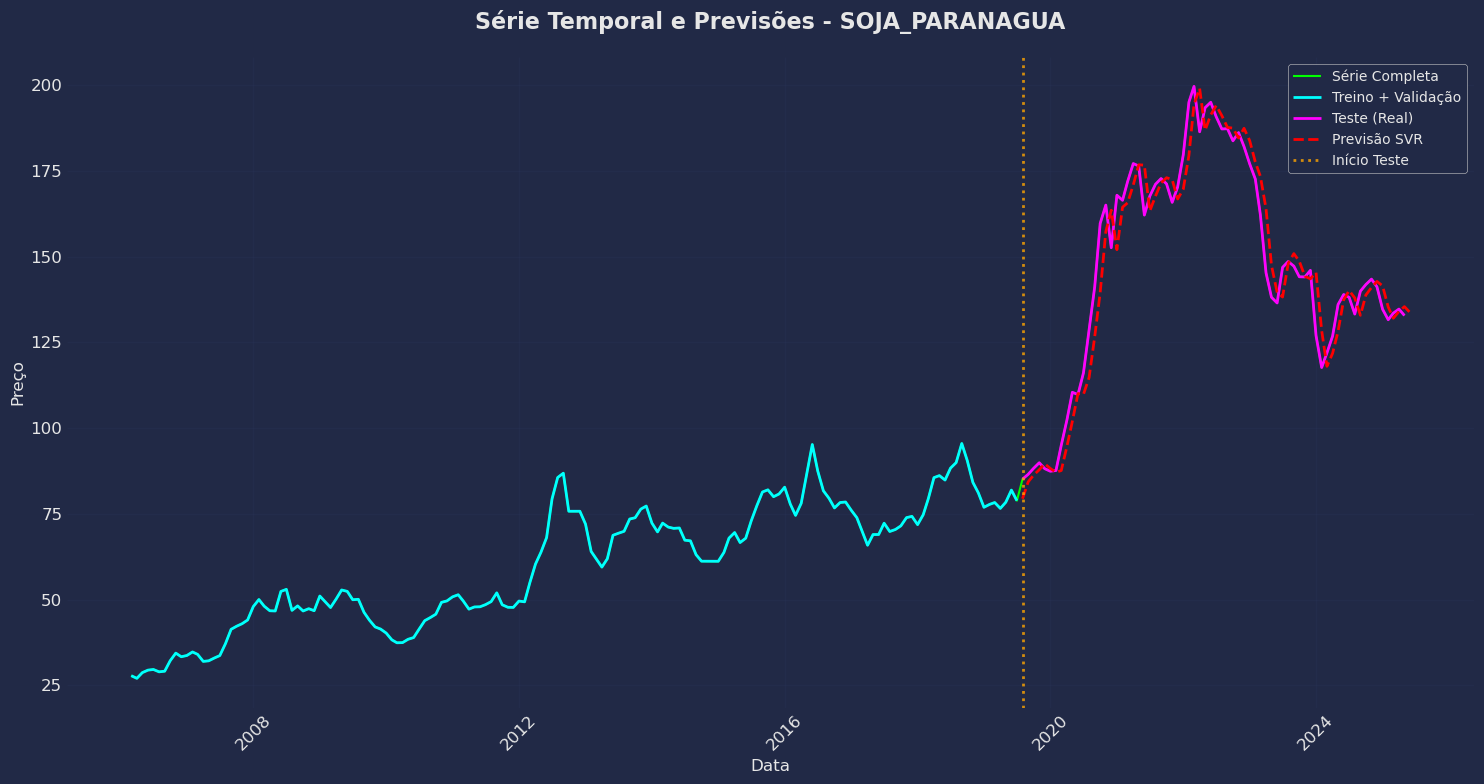

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


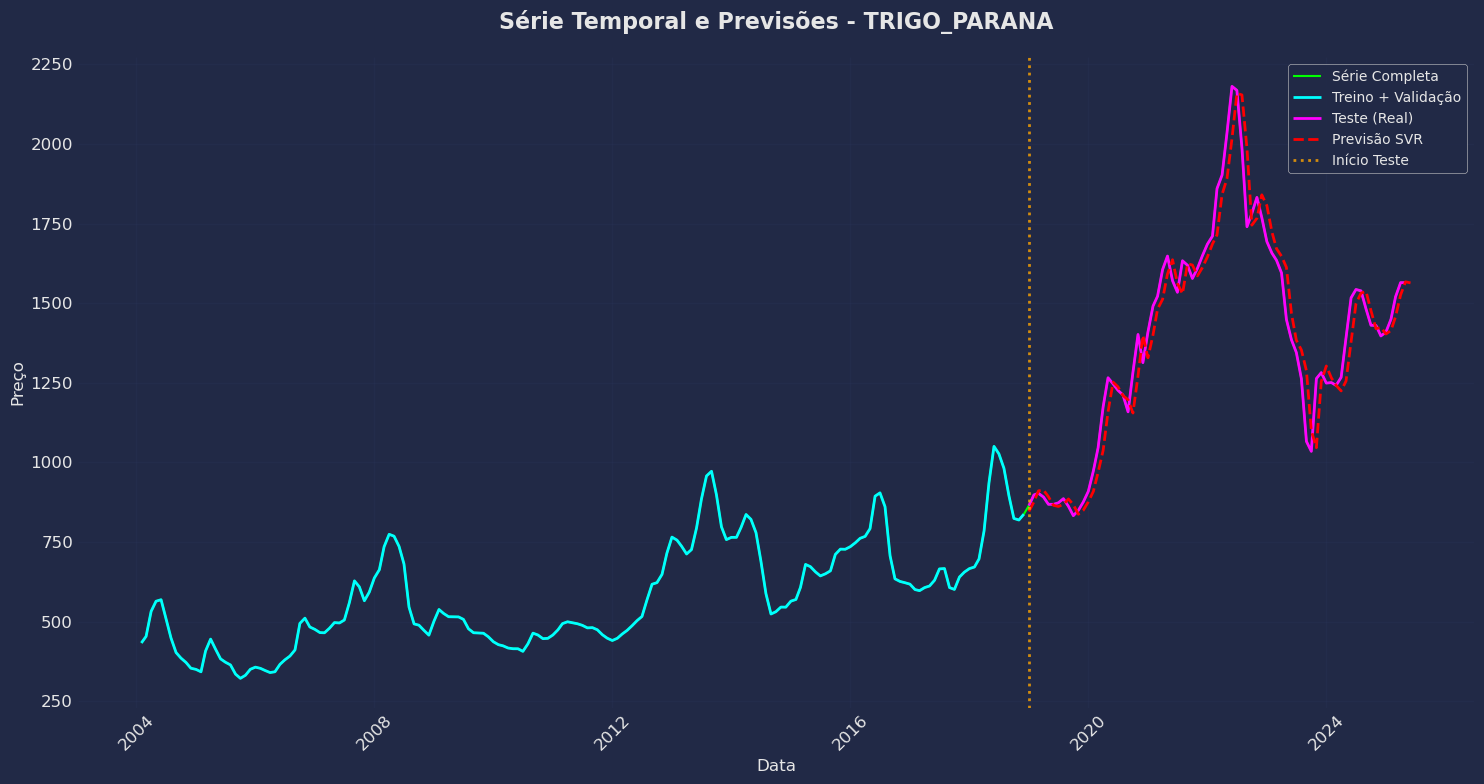

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


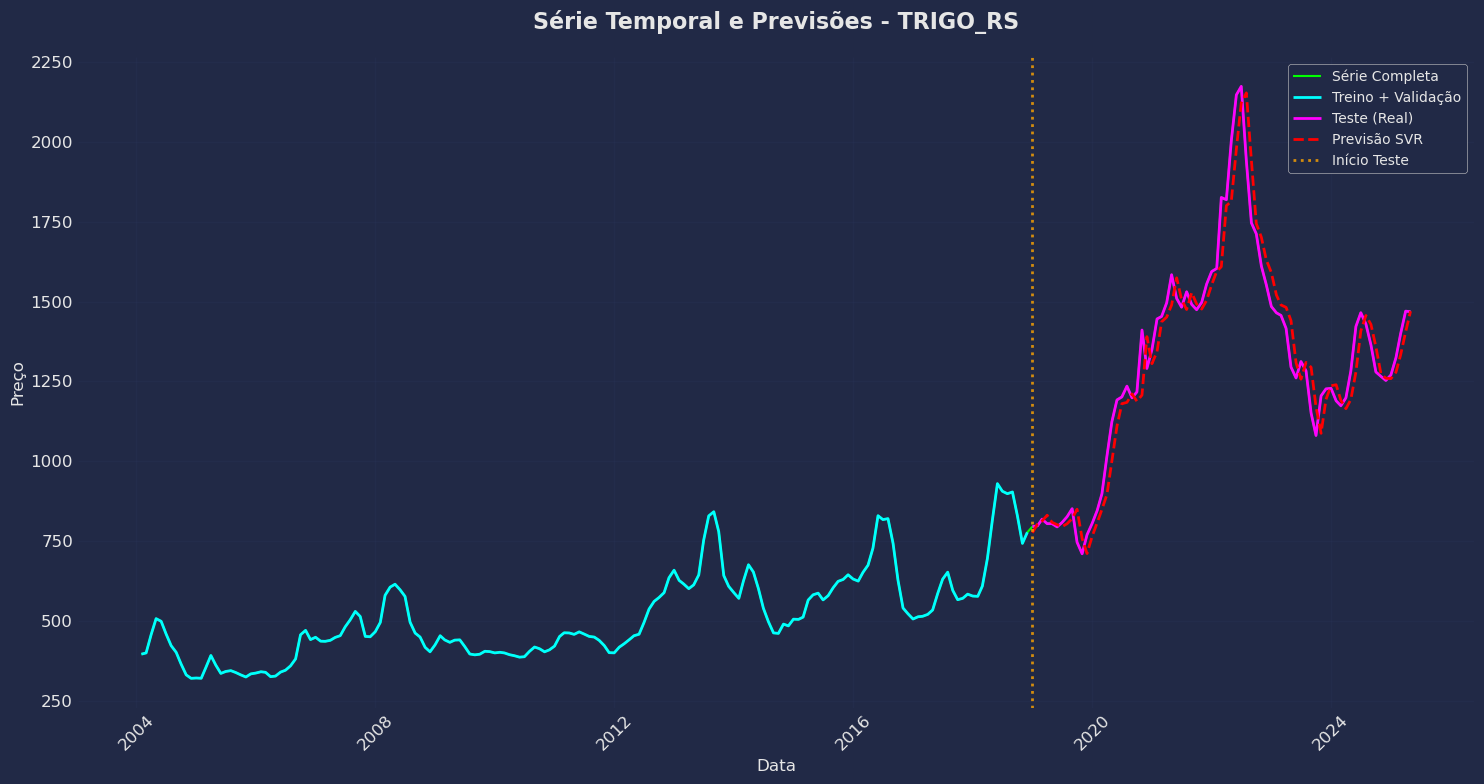

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [ ]:
plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)